# Combining ReacLib Rates with Electron Capture Tables

Here's an example of using tabulated weak rates from Suzuki et a. (2016) together with rates from the ReacLib database.

We'll build a network suitable for e-capture supernovae.

In [1]:
import pynucastro as pyna

First create a library from ReacLib using a set of nuclei.

In [2]:
reaclib_library = pyna.ReacLibLibrary()

all_nuclei = ["p","he4","ne20","o20","f20","mg24","al27","o16","si28","s32","p31"]
ecsn_library = reaclib_library.linking_nuclei(all_nuclei,with_reverse=True)

Here are the rates it chose

In [3]:
print(ecsn_library)

o16 + he4 --> ne20             [Q =   4.73 MeV] (o16 + he4 --> ne20 <co10_reaclib__>)
o16 + o16 --> p + p31          [Q =   7.68 MeV] (o16 + o16 --> p + p31 <cf88_reaclib__>)
o16 + o16 --> he4 + si28       [Q =   9.59 MeV] (o16 + o16 --> he4 + si28 <cf88_reaclib__>)
ne20 + he4 --> mg24            [Q =   9.32 MeV] (ne20 + he4 --> mg24 <il10_reaclib__>)
f20 --> ne20                   [Q =   7.02 MeV] (f20 --> ne20 <wc12_reaclib_weak_>)
o20 --> f20                    [Q =   3.81 MeV] (o20 --> f20 <wc12_reaclib_weak_>)
mg24 + he4 --> si28            [Q =   9.98 MeV] (mg24 + he4 --> si28 <st08_reaclib__>)
al27 + p --> si28              [Q =  11.59 MeV] (al27 + p --> si28 <il10_reaclib__>)
al27 + p --> he4 + mg24        [Q =   1.60 MeV] (al27 + p --> he4 + mg24 <il10_reaclib__>)
al27 + he4 --> p31             [Q =   9.67 MeV] (al27 + he4 --> p31 <ths8_reaclib__>)
si28 + he4 --> s32             [Q =   6.95 MeV] (si28 + he4 --> s32 <ths8_reaclib__>)
p31 + p --> s32                [Q =   8.86 M

Now let's specify the weak rates we want from Suzuki et al. -- these tables are included with pynucastro:

In [4]:
ecsn_tabular = ["f20--o20-toki","ne20--f20-toki","o20--f20-toki","f20--ne20-toki"]

These tables are in terms of $T$ and $\rho Y_e$.  We can easily plot the tabulated electron capture rates just like ReacLib rates:

/home/zingale/development/pynucastro/pynucastro/rates/rate.py:895: RuntimeWarning: divide by zero encountered in log10
  pivot_table[row_pos, col_pos] = np.log10(data_heatmap[:, 5])


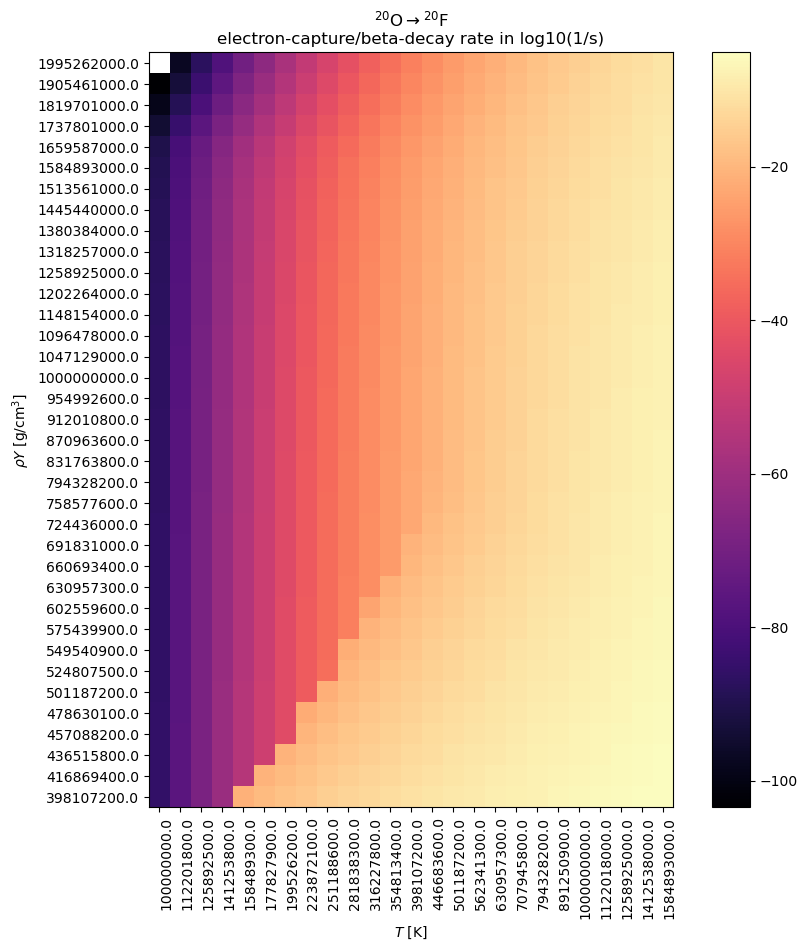

In [5]:
a = pyna.Rate("o20--f20-toki")
fig = a.plot()

Let's create a rate collection from the ReacLib rates and look to see which are actually important

In [6]:
rc = pyna.RateCollection(libraries=[ecsn_library])

Here we'll pick thermodynamic conditions appropriate to the oxygen burning shell in a white dwarf

In [7]:
comp = pyna.Composition(rc.get_nuclei())
comp.set_nuc("o16", 0.5)
comp.set_nuc("ne20", 0.3)
comp.set_nuc("mg24", 0.1)
comp.set_nuc("o20", 1.e-5)
comp.set_nuc("f20", 1.e-5)
comp.set_nuc("p", 1.e-5)
comp.set_nuc("he4", 1.e-2)
comp.set_nuc("al27", 1.e-2)
comp.set_nuc("si28", 1.e-2)
comp.set_nuc("s32", 1.e-2)
comp.set_nuc("p31", 1.e-2)
comp.normalize()

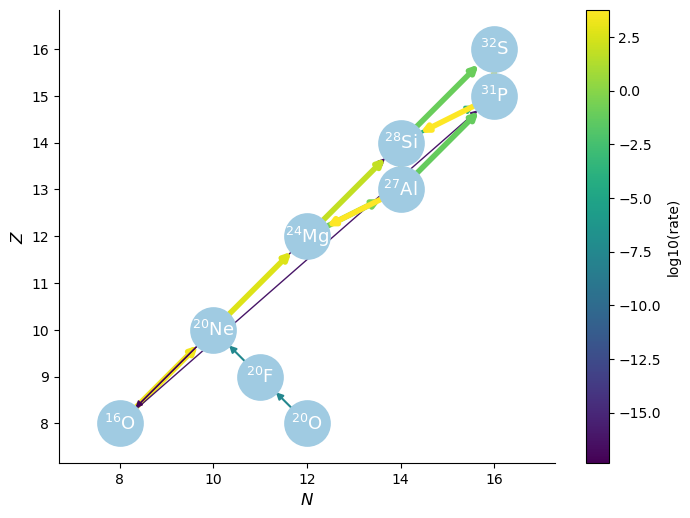

In [8]:
rc.plot(rho=7.e9, T=1.e9, comp=comp, ydot_cutoff_value=1.e-20)

Now, this rate collection already includes some weak rates from ReacLib -- we want to remove those.  We'll also take the opportunity to remove any rates that are not important, by looking for a $|\dot{Y}| > 10^{-20}~s^{-1}$.

In [9]:
new_rate_list = []
ydots = rc.evaluate_rates(rho=7.e9, T=1.e9, composition=comp)
for rate in rc.rates:
    if abs(ydots[rate]) >= 1.e-20 and not rate.weak:
        new_rate_list.append(rate)        

Finally, we'll create a new rate collection by combining this new list of rates with the list of tables:

In [10]:
rc_new = pyna.RateCollection(rates=new_rate_list, rate_files=ecsn_tabular)

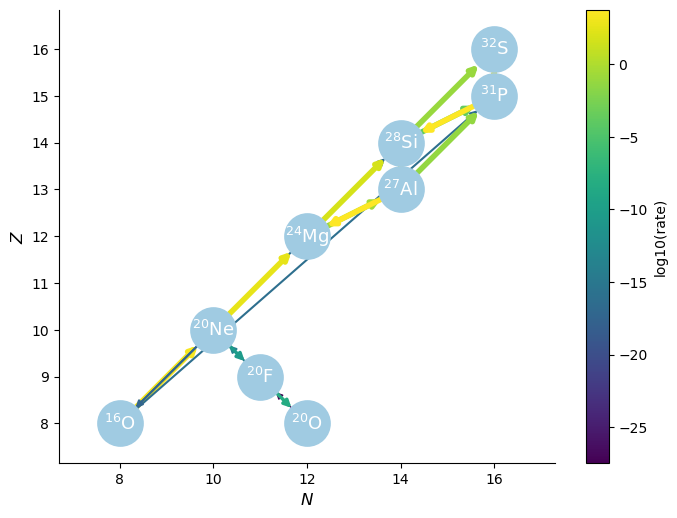

In [11]:
rc_new.plot(rho=7.e9, T=1.e9, comp=comp)

We can see the values of the rates at our thermodynamic conditions easily:

In [12]:
rc_new.evaluate_rates(rho=7.e9, T=1.e9, composition=comp)

OrderedDict([(ne20 --> he4 + o16, 4.631669519815501e-18),
             (o16 + he4 --> ne20, 2163.4896055892013),
             (ne20 + he4 --> mg24, 470.4657166295948),
             (mg24 + he4 --> si28, 65.33425925449087),
             (al27 + p --> si28, 3786.5889540808494),
             (al27 + he4 --> p31, 0.057635811259143355),
             (si28 + he4 --> s32, 0.08322738610569617),
             (p31 + p --> s32, 2375.130496403913),
             (o16 + o16 --> p + p31, 7.154939895463953e-17),
             (o16 + o16 --> he4 + si28, 2.5949312230335836e-17),
             (mg24 + he4 --> p + al27, 0.2543862399303774),
             (al27 + p --> he4 + mg24, 5920.818449985262),
             (si28 + he4 --> p + p31, 0.00019528201299493395),
             (p31 + p --> he4 + si28, 5491.96044267561),
             (f20 --> o20, 4.033041588160375e-09),
             (ne20 --> f20, 3.580914286917256e-11),
             (o20 --> f20, 3.4692267612601718e-28),
             (f20 --> ne20, 1.216193699